In [52]:
import math
from collections import Counter
import seaborn as sns
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

from tokenizers import ByteLevelBPETokenizer

In [2]:
load_dotenv('../.env')

True

In [3]:
tokenizer_path = os.getenv('TOKENIZER_PATH')

In [4]:
tokenizer_path

'L://lab_research/RES-Folder-UPOD/CarTeksten/G_Output/3_OtherOutput/Tokenizer/tokenizer/tokenizer_deid'

In [ ]:
# Use pre-trained tokenizer to get token id's, use for entropy calculation
tokenizer = ByteLevelBPETokenizer.from_file(merges_filename=os.path.join(tokenizer_path, "merges.txt"), 
                                            vocab_filename=os.path.join(tokenizer_path, "vocab.json"))

In [84]:
def get_char_seq(txt):
    """
    Convert the text string into a list (sequence) of character IDs.
    Here we simply use the built-in `ord` to get the ASCII/Unicode code.
    """
    return [ord(ch) for ch in txt]

def get_tok_seq(txt):
    """
    Convert the text string into a list (sequence) of token IDs.
    Here we split the text by whitespace to get tokens.
    """
    return tokenizer.encode(txt).ids

def compute_entropy(counter):
    """
    Given a frequency counter of items in a window, compute Shannon entropy.
    """
    total = sum(counter.values())
    if total == 0:
        return 0.0
    
    entropy = 0.0
    for count in counter.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def get_char_entr(char_id_seq, window=5, stride=1):
    """
    Compute local entropies over a sliding window, and record the spans (start, end).
    Returns:
        char_id_entr (list[float]): A list of entropy values for each window.
        spans (list[tuple]): Corresponding (start, end) indices for each window.
    """
    char_id_entr = []
    spans = []
    n = len(char_id_seq)
    
    for start in range(0, n - window + 1, stride):
        end = start + window
        # Count frequencies of each character ID in the window
        window_ids = char_id_seq[start:end]
        freq_counter = Counter(window_ids)
        
        e = compute_entropy(freq_counter)
        char_id_entr.append(e)
        spans.append((start, end))
    
    return char_id_entr, spans

def get_cand_dupl(char_id_entr, spans, threshold=1.0):
    """
    Identify spans of low entropy (potential spurious repetition).
    
    Args:
        char_id_entr: A list of entropy values for each window.
        spans: The corresponding spans (start, end) for each window.
        threshold: Entropy threshold below which a span is considered "repetitive".
    
    Returns:
        candidate_spans (list[tuple]): Spans that may be spurious duplicates.
    """
    candidate_spans = []
    entropy_list = []
    for e, (start, end) in zip(char_id_entr, spans):
        entropy_list.append(e)
        if e < threshold:
            candidate_spans.append((start, end))
    return candidate_spans, entropy_list

def recombine(spans, candidate_spans, text):
    """
    Removes characters in all candidate_spans from the original text.
    
    Args:
        spans (list[tuple]): Not strictly necessary if we already have candidate_spans,
                             but sometimes you might use 'spans' to figure out something else.
        candidate_spans (list[tuple]): The (start, end) index ranges to remove.
        text (str): The original text string.

    Returns:
        new_text (str): Reconstructed text with spurious spans removed.
    """
    to_remove = set()
    for (start, end) in candidate_spans:
        # Mark all indices in the range [start, end) for removal
        to_remove.update(range(start, end))

    # Build new text by skipping removed indices
    new_chars = []
    for i, ch in enumerate(text):
        if i not in to_remove:
            new_chars.append(ch)
    
    return "".join(new_chars)

def spurious_repetitions(txt):
    '''
        Takes in text and removes spurious repetitions
        txt: text to process
    '''
    # using regex is too expensive (search space very large)
    # better to look at character entropy first.

    char_id_seq = get_char_seq(txt)
    char_id_entr, spans = get_char_entr(char_id_seq, window=5, stride=1)
    get_candidate_spans, _ = get_cand_dupl(char_id_entr, spans, threshold=1)
    txt = recombine(spans, get_candidate_spans, txt)

    return txt

het mogelijk is de stopweek over te slaan en direct aaip, vaginale ring of pleister te starten (zie Details)
gebruik van een tweedegeneratiepreparaat de voorkeur heeft (zie ook NHG-Standaard Anticonceptie)
continu gebruik van deze vormen van anticonceptie veilig aaa aaa aaa aaa aaa aaa aaa aaa aaa is bevonden voor de periode van 1 jaar (langere termijn is niet onderzocht)
er theoretisch geen redenen zijn om aan te nemen dat continu gebruik meer risico’s met zich meebrengt dan cyclisch gebruik
bij continu gebruik van anticonceptie de kans op doorbraakbloedingen toeneemt met de duur van het gebruik; in dat geval wordt geadviseerd 4 tot 7 stopdagen in te lassen.


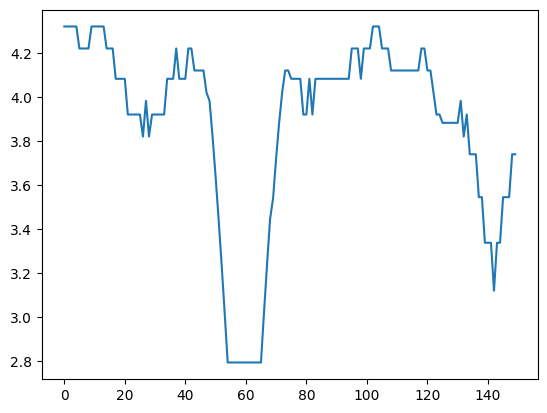

In [87]:
example_text = """het mogelijk is de stopweek over te slaan en direct aansluitend met een nieuwe pilstrip, vaginale ring of pleister te starten (zie Details)
gebruik van een tweedegeneratiepreparaat de voorkeur heeft (zie ook NHG-Standaard Anticonceptie)
continu gebruik van deze vormen van anticonceptie veilig aaa aaa aaa aaa aaa aaa aaa aaa aaa is bevonden voor de periode van 1 jaar (langere termijn is niet onderzocht)
er theoretisch geen redenen zijn om aan te nemen dat continu gebruik meer risico’s met zich meebrengt dan cyclisch gebruik
bij continu gebruik van anticonceptie de kans op doorbraakbloedingen toeneemt met de duur van het gebruik; in dat geval wordt geadviseerd 4 tot 7 stopdagen in te lassen."""

char_id_seq = get_tok_seq(example_text)
char_id_entr, spans = get_char_entr(char_id_seq, window=20, stride=1)
get_candidate_spans, entropy_list = get_cand_dupl(char_id_entr, spans, 3)
txt = recombine(spans, get_candidate_spans, example_text)

print(txt)

plt.plot(entropy_list)


In [79]:
list(range(0, 100,10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]